# Dataframe preparation and classifiers

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

%matplotlib inline

np.random.seed(7834)

Foolishly, the first time I scraped, I did not include the current time in the data scraping processes, so after I finished scraping I got the current time and put them here. These times may be off by at most 10 minutes (I measured the time when the scraping finished and saved the numbers).

In [83]:
bpt_time = 1527700578.5692391
wpt_time = 1527714986.933973

## Data Cleaning
Right now at least, I see no reason not to combine all the text into one cell, separated by a space so the words aren't mashed together. I'll also assign a class variable (`0` for `r/BlackPeopleTwitter` and `1` for `r/WhitePeopleTwitter`).

In [84]:
df1 = pd.read_csv('bpt_scraped_109pm_may30.csv', index_col=0)

df1['time_on_reddit'] = bpt_time - df1['created_utc']

df1.drop(['created_utc'], axis = 1, inplace=True)

df1['total_text'] = df1['body'] + ' ' + df1['post_title']

df1.drop(['body', 'post_title'], axis = 1, inplace=True)

df1['class'] = 0

In [85]:
df1.head()

,comments_this_post,ups,time_on_reddit,total_text,class
0,138,5,43776.569239,Fuck I thought it was Sophie Dee. That would h...,0
1,591,1464,58805.569239,"As a surprise to zero people, Pusha T is a lot...",0
2,72,439,13024.569239,"That or ""I am hiding a child, but you're hidin...",0
3,1153,3281,49606.569239,She should have talked about Mexicans. Nobody ...,0
4,66,55,12486.569239,I’ve never seen a single tweet blow up in a ce...,0


A little exploration of the data here: the script below makes a list of the 20 most common words in the text (not including stopwords).

In [121]:
cvec = CountVectorizer(stop_words='english')
df1_transformed = cvec.fit_transform(df1['total_text'])

pd.DataFrame(([pd.DataFrame(df1_transformed.toarray(), columns = cvec.get_feature_names()).sum()])).T.sort_values(by = 0, ascending = False).head(20)

,0
like,144
just,125
don,98
people,72
shit,71
black,60
got,58
drake,53
good,49
know,48


The same for the `r/WhitePeopleTwitter` data.

In [86]:
df2 = pd.read_csv('wpt_may30_516pm.csv', index_col=0)

df2['time_on_reddit'] = wpt_time - df2['created_utc']

df2.drop(['created_utc'], axis = 1, inplace=True)

df2['total_text'] = df2['body'] + ' '+ df2['post_title']

df2.drop(['body', 'post_title'], axis = 1, inplace=True)

df2['class'] = 1

In [87]:
df2.head()

,comments_this_post,ups,time_on_reddit,total_text,class
0,245,1152,29874.933973,Lions only live 10-14 years in the wild. If I ...,1
1,80,110,15877.933973,That's going to have a disastrous affect on th...,1
2,182,1394,51255.933973,"At 32 years old, I was grocery shopping and so...",1
3,29,29,14178.933973,"Oh, but us retail workers want to. We really w...",1
4,18,50,30874.933973,"Germany has Dads too Oh, dad. Got me again.",1


In [122]:
cvec = CountVectorizer(stop_words='english')
df2_transformed = cvec.fit_transform(df2['total_text'])

pd.DataFrame(([pd.DataFrame(df2_transformed.toarray(), columns = cvec.get_feature_names()).sum()])).T.sort_values(by = 0, ascending = False).head(20)

,0
like,99
just,92
https,54
don,52
com,51
people,46
know,41
amp,41
time,39
think,36


Combining them into one dataframe.

In [88]:
df = pd.concat([df1, df2])

In [89]:
df['length_of_text'] = df['total_text'].map(lambda x: len(x))

In [90]:
df.head()

,comments_this_post,ups,time_on_reddit,total_text,class,length_of_text
0,138,5,43776.569239,Fuck I thought it was Sophie Dee. That would h...,0,390
1,591,1464,58805.569239,"As a surprise to zero people, Pusha T is a lot...",0,106
2,72,439,13024.569239,"That or ""I am hiding a child, but you're hidin...",0,89
3,1153,3281,49606.569239,She should have talked about Mexicans. Nobody ...,0,108
4,66,55,12486.569239,I’ve never seen a single tweet blow up in a ce...,0,317


## EDA

First, a look at the distributions of the numerical categories:

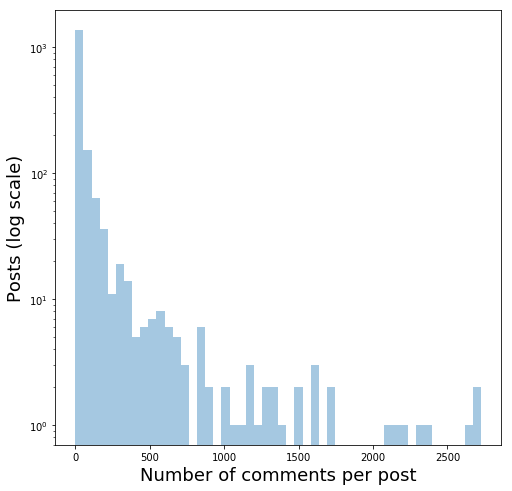

In [91]:
plt.figure(figsize=(8,8))
sns.distplot(df['comments_this_post'], kde=False, hist_kws = {'log':True})
plt.xlabel("Number of comments per post", fontsize = 18)
plt.ylabel("Posts (log scale)", fontsize = 18)
plt.savefig('Comments_log_scale.png')

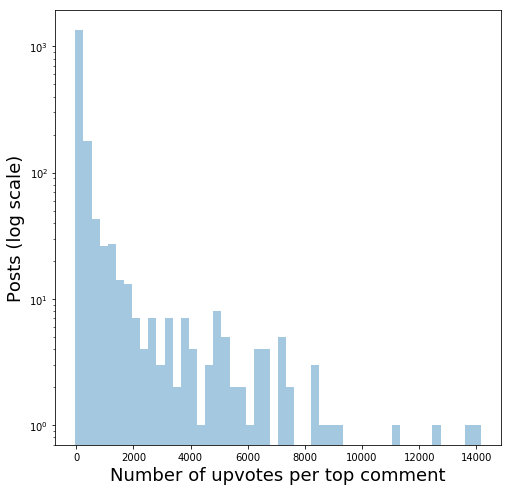

In [92]:
plt.figure(figsize=(8,8))
sns.distplot(df['ups'], kde=False, hist_kws = {'log':True})
plt.xlabel("Number of upvotes per top comment", fontsize = 18)
plt.ylabel("Posts (log scale)", fontsize = 18)
plt.savefig('Upvotes_log_scale.png')

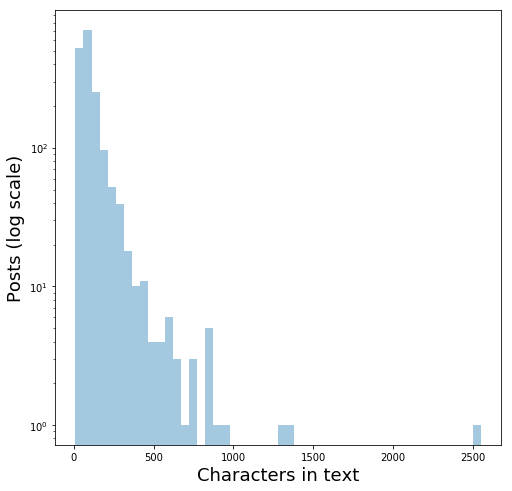

In [93]:
plt.figure(figsize = (8,8))
sns.distplot(df['length_of_text'], kde=False, hist_kws = {'log':True})
plt.xlabel("Characters in text", fontsize = 18)
plt.ylabel("Posts (log scale)", fontsize = 18)
plt.savefig('Characters_log_scale.png')

They all look like they have similar distributions, so they might be correlated.

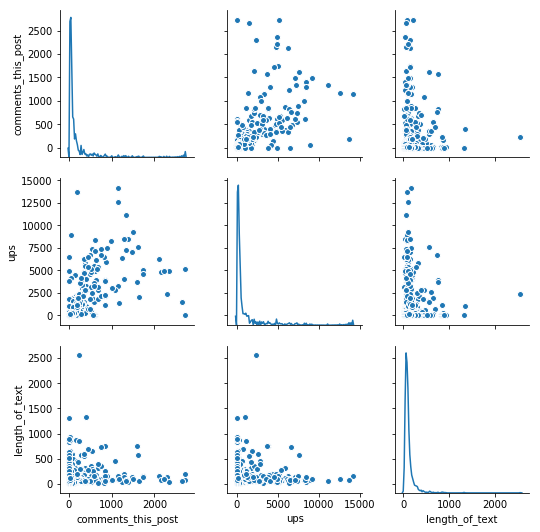

In [94]:
sns.pairplot(df[['comments_this_post','ups','length_of_text']], diag_kind='kde')

Examining correlation more closely and differentiated between subreddits:

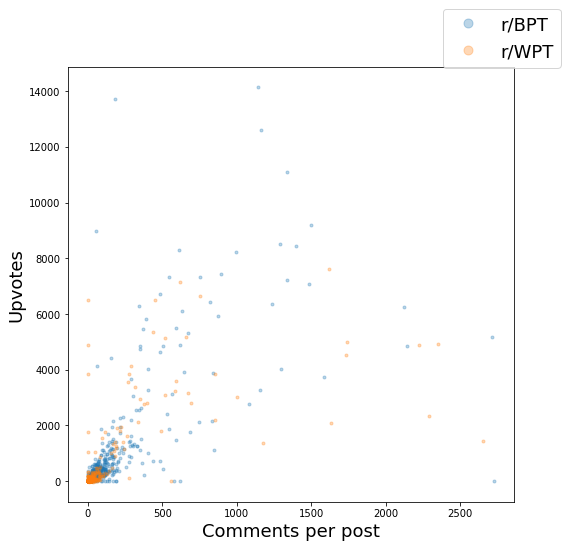

In [95]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.plot(df['comments_this_post'][df['class']==0], df['ups'][df['class']==0], '.', label='r/BPT', alpha = 0.3)
ax.plot(df['comments_this_post'][df['class']==1], df['ups'][df['class']==1], '.', label='r/WPT', alpha = 0.3)
plt.xlabel("Comments per post", fontsize = 18)
plt.ylabel("Upvotes", fontsize = 18)
fig.legend(fontsize = 18, markerscale = 3)
plt.savefig('comments-upvotes.png')


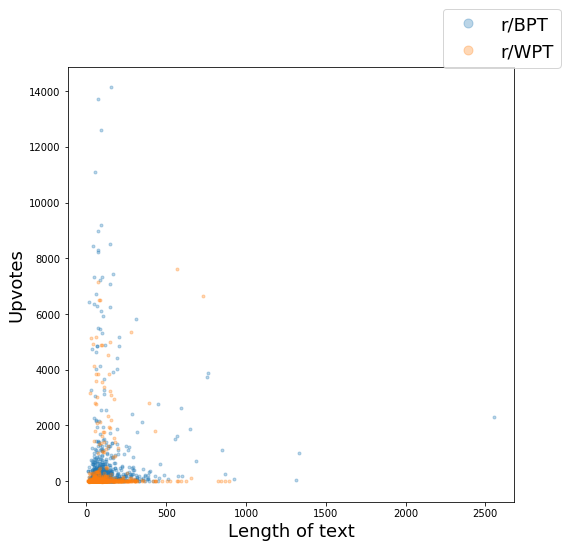

In [96]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.plot(df['length_of_text'][df['class']==0], df['ups'][df['class']==0], '.', label='r/BPT', alpha = 0.3)
ax.plot(df['length_of_text'][df['class']==1], df['ups'][df['class']==1], '.', label ='r/WPT', alpha = 0.3)
plt.xlabel("Length of text", fontsize = 18)
plt.ylabel("Upvotes", fontsize = 18)
fig.legend(fontsize = 18, markerscale = 3)
plt.savefig('chars-upvots.png')


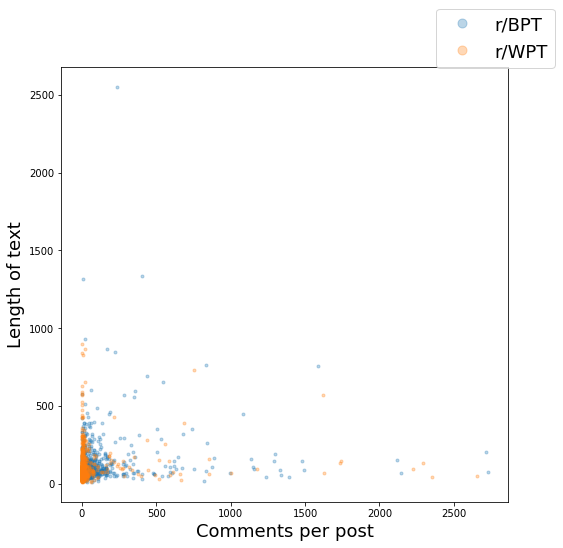

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.plot(df['comments_this_post'][df['class']==0], df['length_of_text'][df['class']==0], '.', label='r/BPT', alpha = 0.3)
ax.plot(df['comments_this_post'][df['class']==1], df['length_of_text'][df['class']==1], '.', label='r/WPT', alpha = 0.3)
plt.xlabel("Comments per post", fontsize = 18)
plt.ylabel("Length of text", fontsize = 18)
fig.legend(fontsize = 18, markerscale = 3)
fig.savefig('comments-chars.png')

Looks like the posts are pretty mixed, with only the outliers really standing out. The vast majority of the data is clumped near the origin for all pariplots, which setting the transparency of the scatterplots really shows.

The more popular class, `r/BlackPeopleTwitter`, captures most of the outliers. This isn't surprising. It's a more popular subreddit with more users, and appears on the front page regularly.

## Classifiers
### Text-only

The simplest NLP model will look only at text, so I'll build a new dataframe called `simple_df` that contains only the `total_text` column and the target (`class`).

In [123]:
pd.set_option('display.max_colwidth', -1)
simple_df = df[['total_text', 'class']]
simple_df.head()

,total_text,class
0,"Fuck I thought it was Sophie Dee. That would have been the only way I could have forgiven drake. \n\nIn other news I think I’m gonna delete this account and take a long ass break from Reddit. Maybe I’ll lurk. I really wish the site were just memes and sports, but the toxic shit is like a magnet to me and I can’t let it ruin me. /r/BlackPeopleTwitter Weekly Discussion Thread - May 26, 2018",0
1,"As a surprise to zero people, Pusha T is a lot better at this than Meek Mill was Pusha-T Responds to Drake",0
2,"That or ""I am hiding a child, but you're hiding TWO CHILDREN."" King Push vs King Pushover",0
3,She should have talked about Mexicans. Nobody would have cared then You can understand how she'd be confused,0
4,"I’ve never seen a single tweet blow up in a celebrities face like this. There have been times where a celebrity tweets or says something stupid and they get backlash but getting your show, which had pretty good ratings btw lol, pulled off the air over a tweet? I know she feels stupid right now. When the Ambien hits",0


Now a train-test split:

In [124]:
target = 'class'
features = 'total_text'
X_train, X_test, y_train, y_test = train_test_split(simple_df[features], simple_df[target], stratify = simple_df['class'])

In [125]:
X_train[:5]

172    Hotel: Trivago titties: out                                                                                                                                                                                                                                                                                                                                                                                                          
795    Knowing I got a 1 but tried my best  Would be better if the seals actually fit the boxes                                                                                                                                                                                                                                                                                                                                             
374    It's #bareminimumtwitterSZN  Get this girl some water!                                                                                 

First, we're going to use the simplest bag-of-words approach and transform the data using `CountVectorizer`.

In [ ]:
cvec = CountVectorizer(ngram_range=(1,2), stop_words='english')
X_train_transformed = cvec.fit_transform(X_train)
X_test_transformed = cvec.transform(X_test)

Now a logistic regression model, which I think is always the model to beat. I'll do some hyperparameter optimization, too.

In [ ]:
logreg1 = LogisticRegression()
logreg_params = {
    "penalty":['l1','l2'],
    'C':np.logspace(-1,2,20)
}
gs_logreg1 = GridSearchCV(logreg1,param_grid=logreg_params)
gs_logreg1.fit(X_train_transformed, y_train)
print("Test score: ", gs_logreg1.score(X_test_transformed, y_test))
print("Best parameters: ", gs_logreg1.best_params_)

So I've taken just the words, and gotten a model that does a little better than guessing. Now a more sophisticated vectorization:

In [126]:
tvec = TfidfVectorizer(ngram_range=(1,3), stop_words='english')
X_train_transformed = tvec.fit_transform(X_train)
X_test_transformed = tvec.transform(X_test)

In [128]:
logreg = LogisticRegression()
logreg_params = {
    'C': np.logspace(-1,3,4),
    'penalty':['l1','l2']
}
gs_logreg = GridSearchCV(logreg,param_grid=logreg_params)
gs_logreg.fit(X_train_transformed, y_train)

print("Best parameters: ", gs_logreg.best_params_)

print("Test score: ", gs_logreg.score(X_test_transformed, y_test))

Best parameters:  {'C': 46.415888336127772, 'penalty': 'l2'}
Test score:  0.66590389016


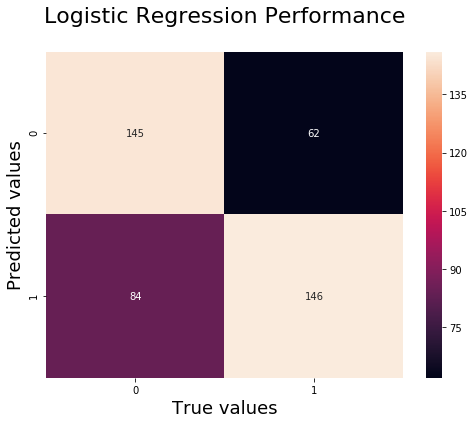

In [131]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, gs_logreg.predict(X_test_transformed)), annot = True, fmt = 'g')
plt.title("Logistic Regression Performance\n", fontsize = 22)
plt.xlabel("True values", fontsize = 18)
plt.ylabel("Predicted values",fontsize = 18)
plt.savefig('logreg-text-only-confusionmatrix.png')

## Other models to try on the text-only data
### AdaBoost

In [ ]:
ada = AdaBoostClassifier()
ada_params = {
    'n_estimators': range(40,60,5)

}
gs_ada = GridSearchCV(ada, param_grid=ada_params)
gs_ada.fit(X_train_transformed, y_train)
print(gs_ada.best_score_)
print(gs_ada.best_params_)

In [ ]:
gs_ada.score(X_test_transformed, y_test)

Rather worse...

### GradientBoostingClassifier

In [ ]:
gb = GradientBoostingClassifier()
gb_params = {
    'n_estimators': range(80,120,5)
}
gs_gb = GridSearchCV(gb, param_grid=gb_params)
gs_gb.fit(X_train_transformed, y_train)
print(gs_gb.best_score_)
print(gs_gb.best_params_)

In [ ]:
gs_gb.score(X_test_transformed, y_test)

Not much better...
### RandomForest

In [132]:
rforest = RandomForestClassifier(n_jobs = -1)
rforest_params = {
    'n_estimators': range(1,20, 2),
    'max_features': [None, 'sqrt','log2', 0.2],
    'min_samples_leaf': range(1,81,10)
}
gs_rforest = GridSearchCV(rforest, param_grid=rforest_params)
gs_rforest.fit(X_train_transformed, y_train)
gs_rforest.score(X_test_transformed, y_test)

0.62700228832951943

In [133]:
gs_rforest.best_params_

{'max_features': 0.2, 'min_samples_leaf': 1, 'n_estimators': 13}

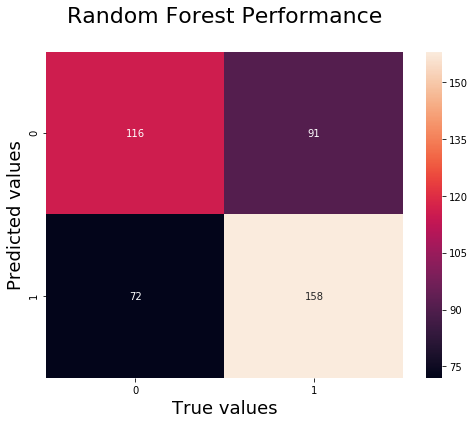

In [136]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, gs_rforest.predict(X_test_transformedsformed)), annot = True, fmt = 'g')
plt.title("Random Forest Performance\n", fontsize = 22)
plt.xlabel("True values", fontsize = 18)
plt.ylabel("Predicted values",fontsize = 18)
plt.savefig('random-forest-text-confusionmatrix.png')

All that gridsearching produced an... OK model, but not better than logisitic regression!

## More complex model

Now that we've seen the limitations of using this limited amount of text alone, let's try to build a stronger model using more features.

In [139]:
list(df.columns) # More easily-readable way to display the number of columns.

['comments_this_post',
 'ups',
 'time_on_reddit',
 'total_text',
 'class',
 'length_of_text']

In [140]:
num_features = ['comments_this_post','ups','time_on_reddit','length_of_text']
num_df = df[num_features]
num_df.head()

,comments_this_post,ups,time_on_reddit,length_of_text
0,138,5,43776.569239,390
1,591,1464,58805.569239,106
2,72,439,13024.569239,89
3,1153,3281,49606.569239,108
4,66,55,12486.569239,317


Because we are going to try to add the numeric columns to the vectorized columns after TfidfVectorizer transforms the text, we have to wait until after this transformation to do our test-train split.

In [141]:
tvec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
vectorized = tvec.fit_transform(df['total_text'])

In [142]:
concat_df = pd.DataFrame(vectorized.todense(), columns = tvec.get_feature_names())

In [143]:
concat_df.index # the concat_df index is in order, but the numerical index isn't which will cause problems  

RangeIndex(start=0, stop=1747, step=1)

In [144]:
num_df.index = concat_df.index # so we reset the numerical df index so they match and then concatenate.
new = pd.concat([concat_df, num_df], axis = 1)

In [145]:
new['class'].value_counts() 
# Notice that there is a column called 'class' in the new dataframe! This is because that word appears in the corpus.

0.000000    1736
0.235520    1   
0.093874    1   
0.103565    1   
0.069530    1   
0.115905    1   
0.159370    1   
0.132947    1   
0.071672    1   
0.088491    1   
0.122936    1   
0.112197    1   
Name: class, dtype: int64

In [146]:
X_train, X_test, y_train, y_test = train_test_split(new, df['class']) # Now we can train-test split

## Models
### Logistic regression
The one to beat!

In [46]:
logreg = LogisticRegression()
logreg_params = {
    'C': np.logspace(-1,2,4),
    'penalty':['l1','l2']
}

gs_logreg = GridSearchCV(logreg, logreg_params)

gs_logreg.fit(X_train, y_train)
gs_logreg.score(X_test, y_test)

0.66132723112128144

In [48]:
print(gs_logreg.best_params_)

{'C': 10.0, 'penalty': 'l1'}


In [147]:
logreg = LogisticRegression(C=10, penalty='l1')
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_train, y_train, cv=5)

array([ 0.6221374 ,  0.70610687,  0.69465649,  0.67175573,  0.70229008])

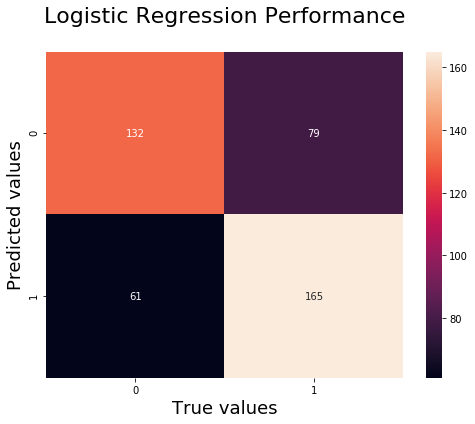

In [150]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, logreg.predict(X_test)), annot = True, fmt = 'g')
plt.title("Logistic Regression Performance\n", fontsize = 22)
plt.xlabel("True values", fontsize = 18)
plt.ylabel("Predicted values",fontsize = 18)
plt.savefig('Logreg-confusionmatrix.png')

Now let's try more advanced classifiers on this set. They will probably be better since they have more to go on. We will try Boosting and RandomForest.

In [151]:
ada = AdaBoostClassifier()
ada_params = {

}

gs_ada = GridSearchCV(ada, ada_params)

gs_ada.fit(X_train, y_train)
print(cross_val_score(gs_ada, X_train, y_train, cv = 5))
print(gs_ada.score(X_test, y_test))

[ 0.8129771   0.79389313  0.8129771   0.80916031  0.77099237]
0.830663615561


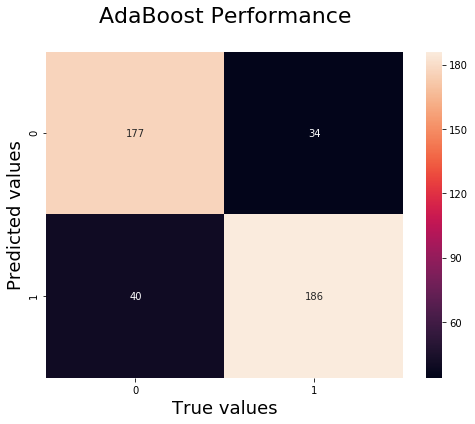

In [153]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, gs_ada.predict(X_test)), annot = True, fmt = 'g')
plt.title("AdaBoost Performance\n", fontsize = 22)
plt.xlabel("True values", fontsize = 18)
plt.ylabel("Predicted values",fontsize = 18)
plt.savefig('AdaBoost-confusionmatrix.png')

In [154]:
rf = RandomForestClassifier()
rf_params = {

}

gs_rf = GridSearchCV(rf, rf_params)

gs_rf.fit(X_train, y_train)
print(cross_val_score(gs_rf, X_train, y_train, cv = 5))
print(gs_rf.score(X_test, y_test))

[ 0.81679389  0.82824427  0.77099237  0.8129771   0.79770992]
0.798627002288


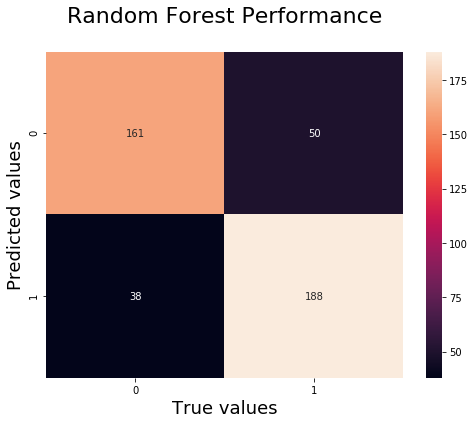

In [155]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, gs_rf.predict(X_test)), annot = True, fmt = 'g')
plt.title("Random Forest Performance\n", fontsize = 22)
plt.xlabel("True values", fontsize = 18)
plt.ylabel("Predicted values",fontsize = 18)
plt.savefig('rf-confusionmatrix-fulldata.png')

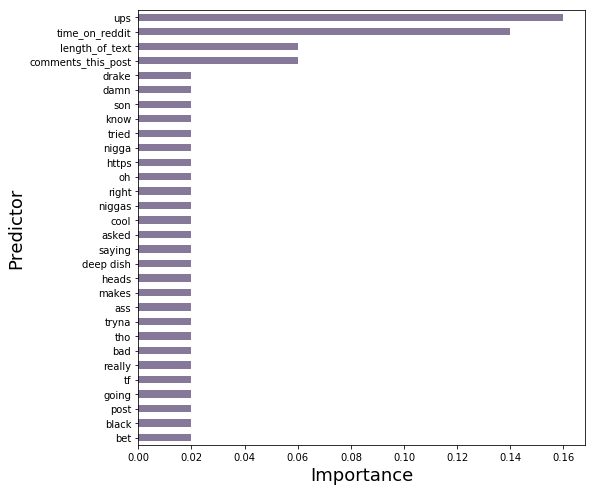

In [177]:
importance = gs_ada.best_estimator_.feature_importances_
cols = new.columns

plot_df = pd.DataFrame({
    'importance':importance,
    'feature':cols
})


most_important = plot_df.sort_values(by='importance', ascending = False).iloc[:30,:]
most_important = most_important.sort_values(by = 'importance')
most_important.set_index('feature', inplace=True)
plt.figure(figsize=(8,8))
ax = most_important.importance.plot(kind='barh',facecolor='#867899')
plt.xlabel("Importance", fontsize = 18)
plt.ylabel("Predictor", fontsize = 18)
plt.savefig('AdaBoost-Best-Predictors.png')

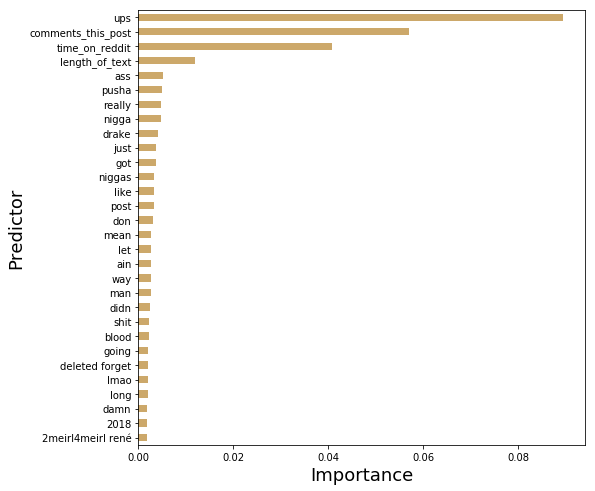

In [178]:
importance = gs_rf.best_estimator_.feature_importances_
cols = new.columns

plot_df = pd.DataFrame({
    'importance':importance,
    'feature':cols
})


most_important = plot_df.sort_values(by='importance', ascending = False).iloc[:30,:]
most_important = most_important.sort_values(by = 'importance')
most_important.set_index('feature', inplace=True)
plt.figure(figsize=(8,8))
ax = most_important.importance.plot(kind='barh',facecolor='#cca86a')
plt.xlabel("Importance", fontsize = 18)
plt.ylabel("Predictor", fontsize = 18)
plt.savefig('RandomForest-Best-Predictors.png')

Now, I scraped some more data (500 observations) and want to see how my  model does classifying them.

In [180]:
bpt_df = pd.read_csv('BPT_june2.csv', index_col=0)
wpt_df = pd.read_csv('Wpt_250_june2.csv', index_col=0)
bpt_df['class'] = 0
wpt_df['class'] = 1
validation_df = pd.concat([bpt_df, wpt_df])

validation_df['time_on_reddit'] = validation_df['current_time'] - validation_df['created_utc']
validation_df['total_text'] = validation_df['body'] + ' ' + validation_df['post_title']
validation_df['length_of_text'] = validation_df['total_text'].map(lambda x: len(x))

target = validation_df['class']

validation_df = validation_df[['comments_this_post', 'ups', 'time_on_reddit', 'total_text','length_of_text']]

validation_df.head()

,comments_this_post,ups,time_on_reddit,total_text,length_of_text
0,89,297,27700.267567,Translation: Pusha killed the man. This is over because stabbing a corpse is unbecoming. im about love,102
1,529,4457,45995.772250,That and pay off my student loans \n\nGods plan Laying pipe,58
2,38,92,7858.814043,Brooo never forget Cyberchase Quality Educational Programming,61
3,25,133,38519.551361,Make sure your opponent sees it and you can roll a skill check for intimidation... [Alchemy 100],97
4,2506,31446,62430.822029,"Because he wasn't in blackface, his character was. It's a subtle but very important distinction. ""What do *you* mean you people?""",130


Same process for data cleaning:

In [181]:
validation_num_df = validation_df[num_features]
validation_vectorized = tvec.transform(validation_df['total_text'])
validation_concat_df = pd.DataFrame(validation_vectorized.todense(), columns = tvec.get_feature_names())
validation_num_df.index = validation_concat_df.index
validation_total = pd.concat([validation_concat_df, validation_num_df], axis = 1)

#Now the scores on this validation set:
gs_ada.score(validation_total,target)

0.78853754940711462

In [182]:
gs_rf.score(validation_total, target)

0.7865612648221344

**How do these models do with confusion matrices?** 

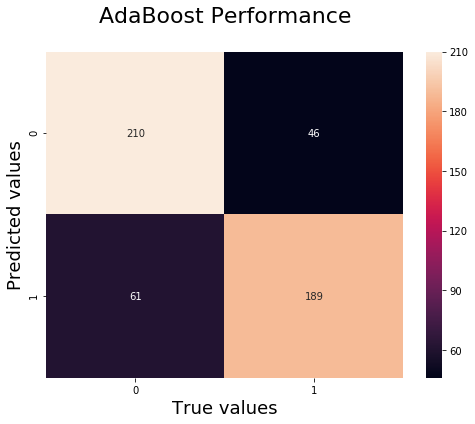

In [186]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(target, gs_ada.predict(validation_total)), annot = True, fmt = 'g')
plt.title("AdaBoost Performance\n", fontsize = 22)
plt.xlabel("True values", fontsize = 18)
plt.ylabel("Predicted values",fontsize = 18)
plt.savefig("adaboostconfusionmatrix1.png")

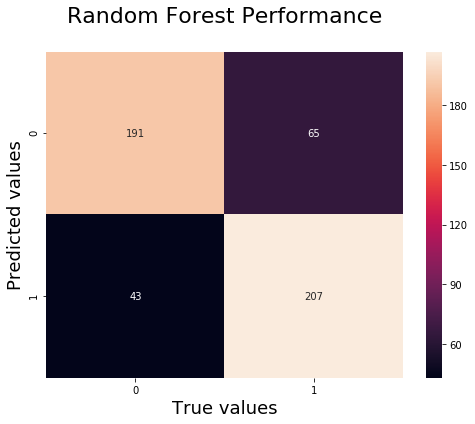

In [187]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(target, gs_rf.predict(validation_total)), annot = True, fmt = 'g')
plt.title("Random Forest Performance\n", fontsize = 22)
plt.xlabel("True values", fontsize = 18)
plt.ylabel("Predicted values",fontsize = 18)
plt.savefig('randomforestconfusionmatrix1.png')